# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import DenseNet121

# Preprocessing

## Train & Test path

In [2]:
train_path = os.path.join('cat-dog-datasets', 'train')
test_path = os.path.join('cat-dog-datasets', 'test')

## Memuat Gambar dan Data Augmentasi

In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [4]:
size_images = 200
batch_size = 64

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 557 images belonging to 2 classes.


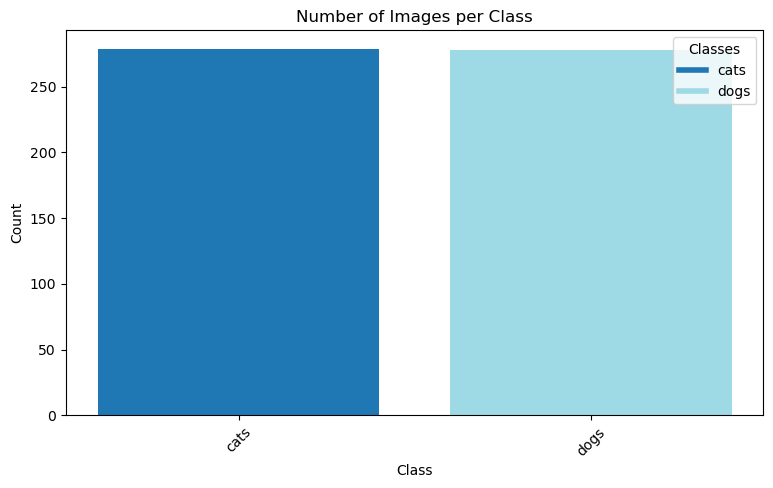

In [6]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(9, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [7]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [8]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 140 images belonging to 2 classes.


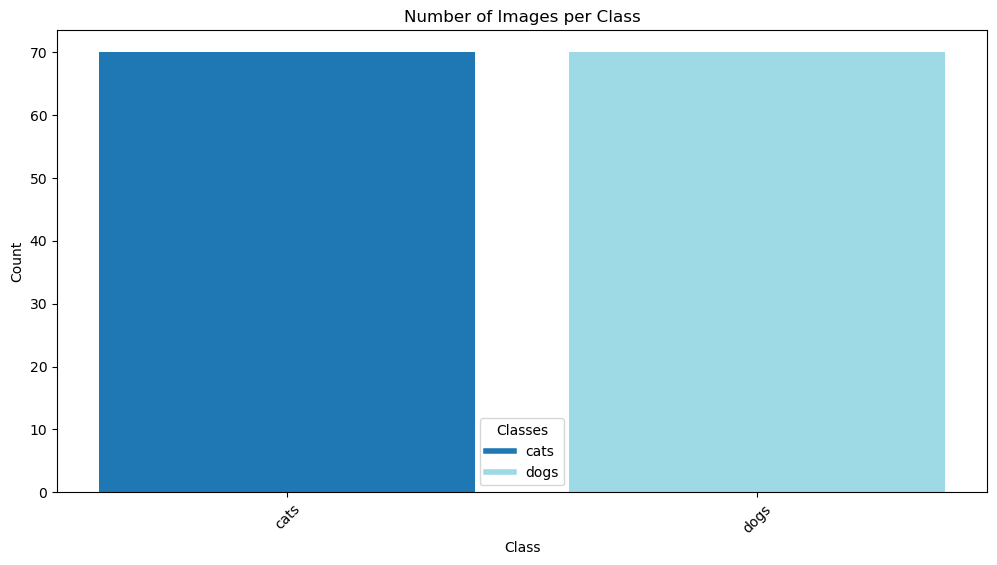

In [9]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

## Menampilkan Gambar

In [10]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

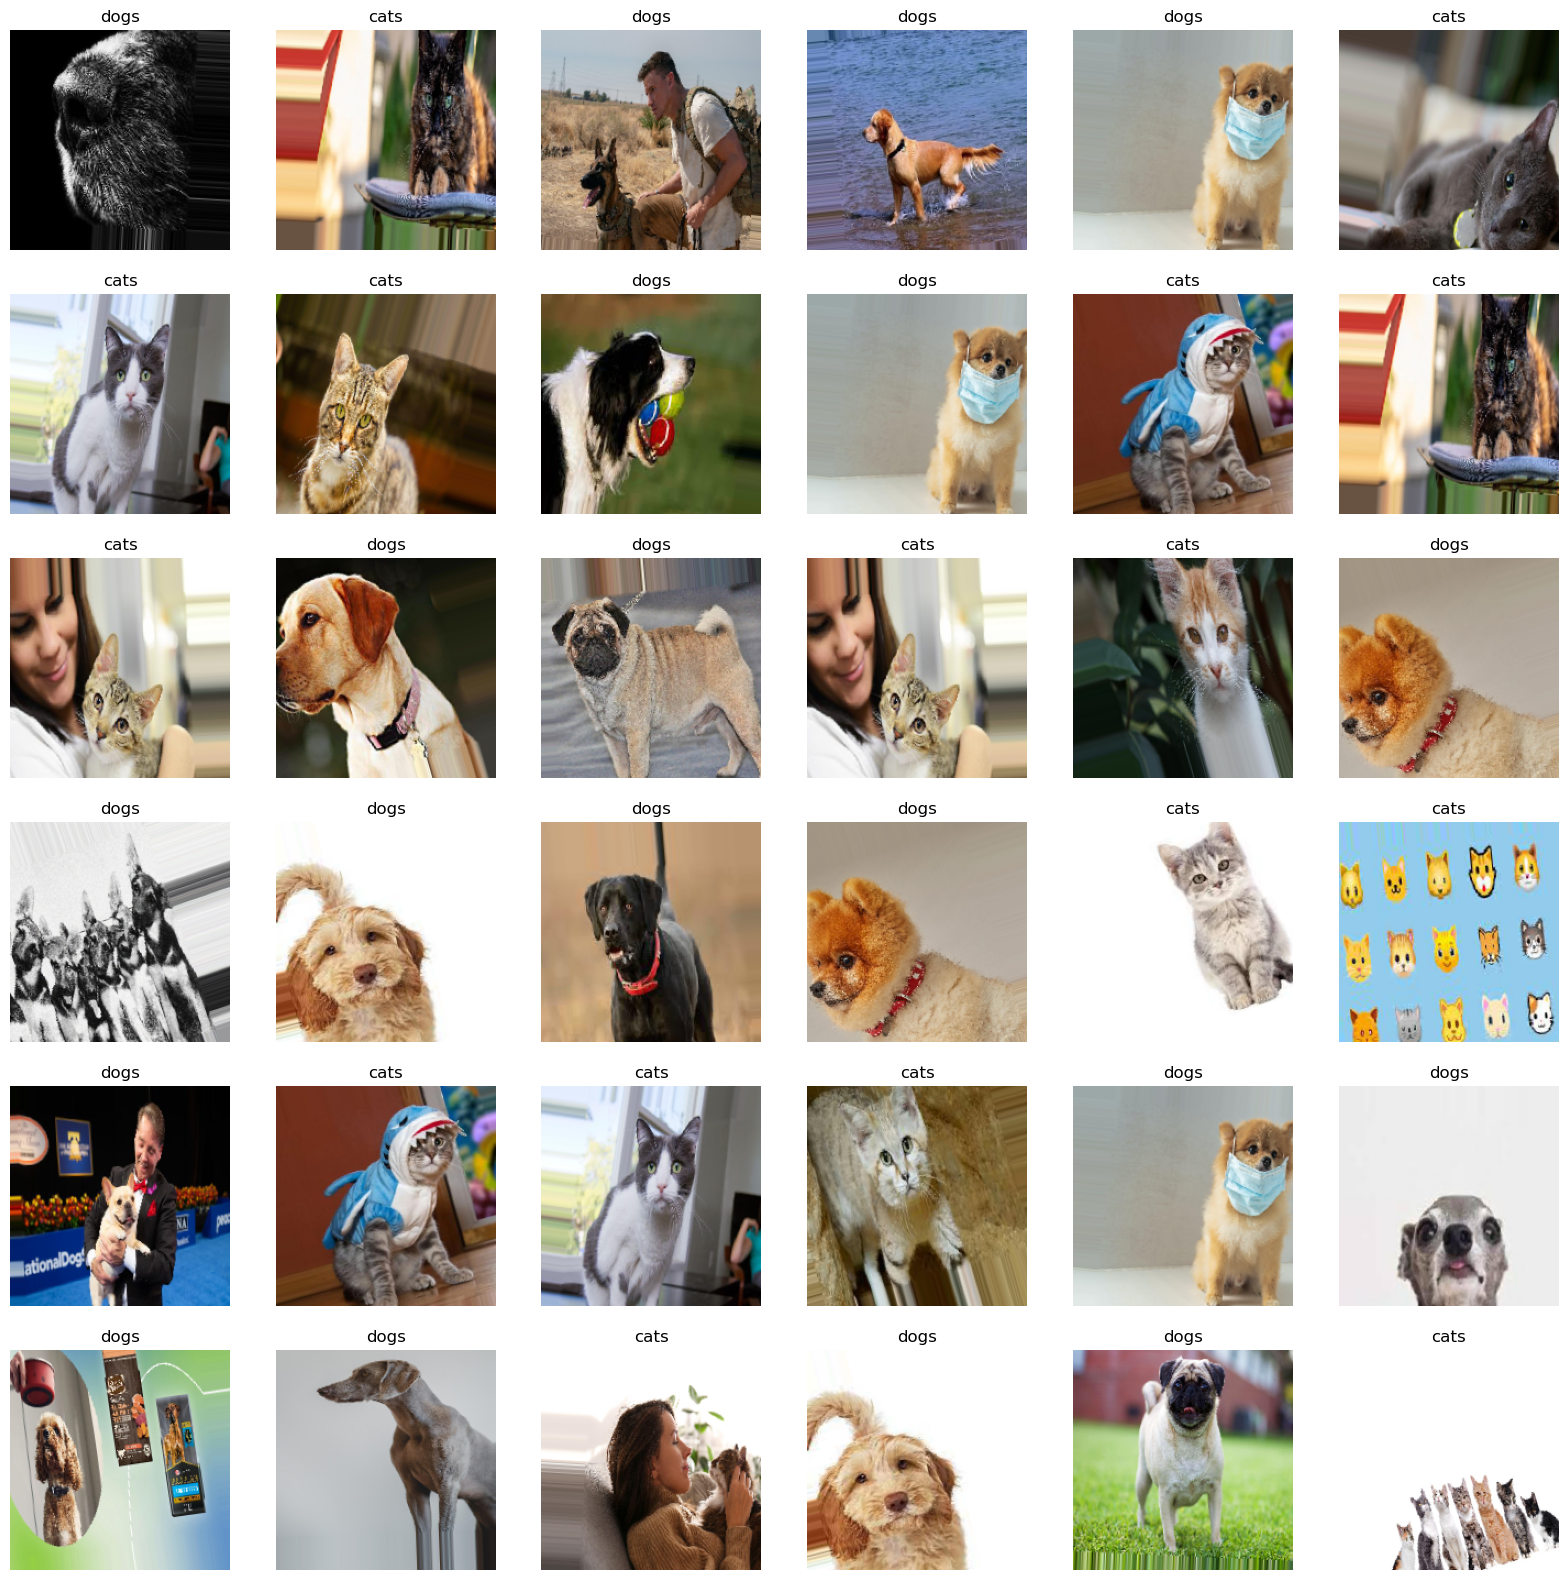

In [11]:
Show_Images(train_generator)

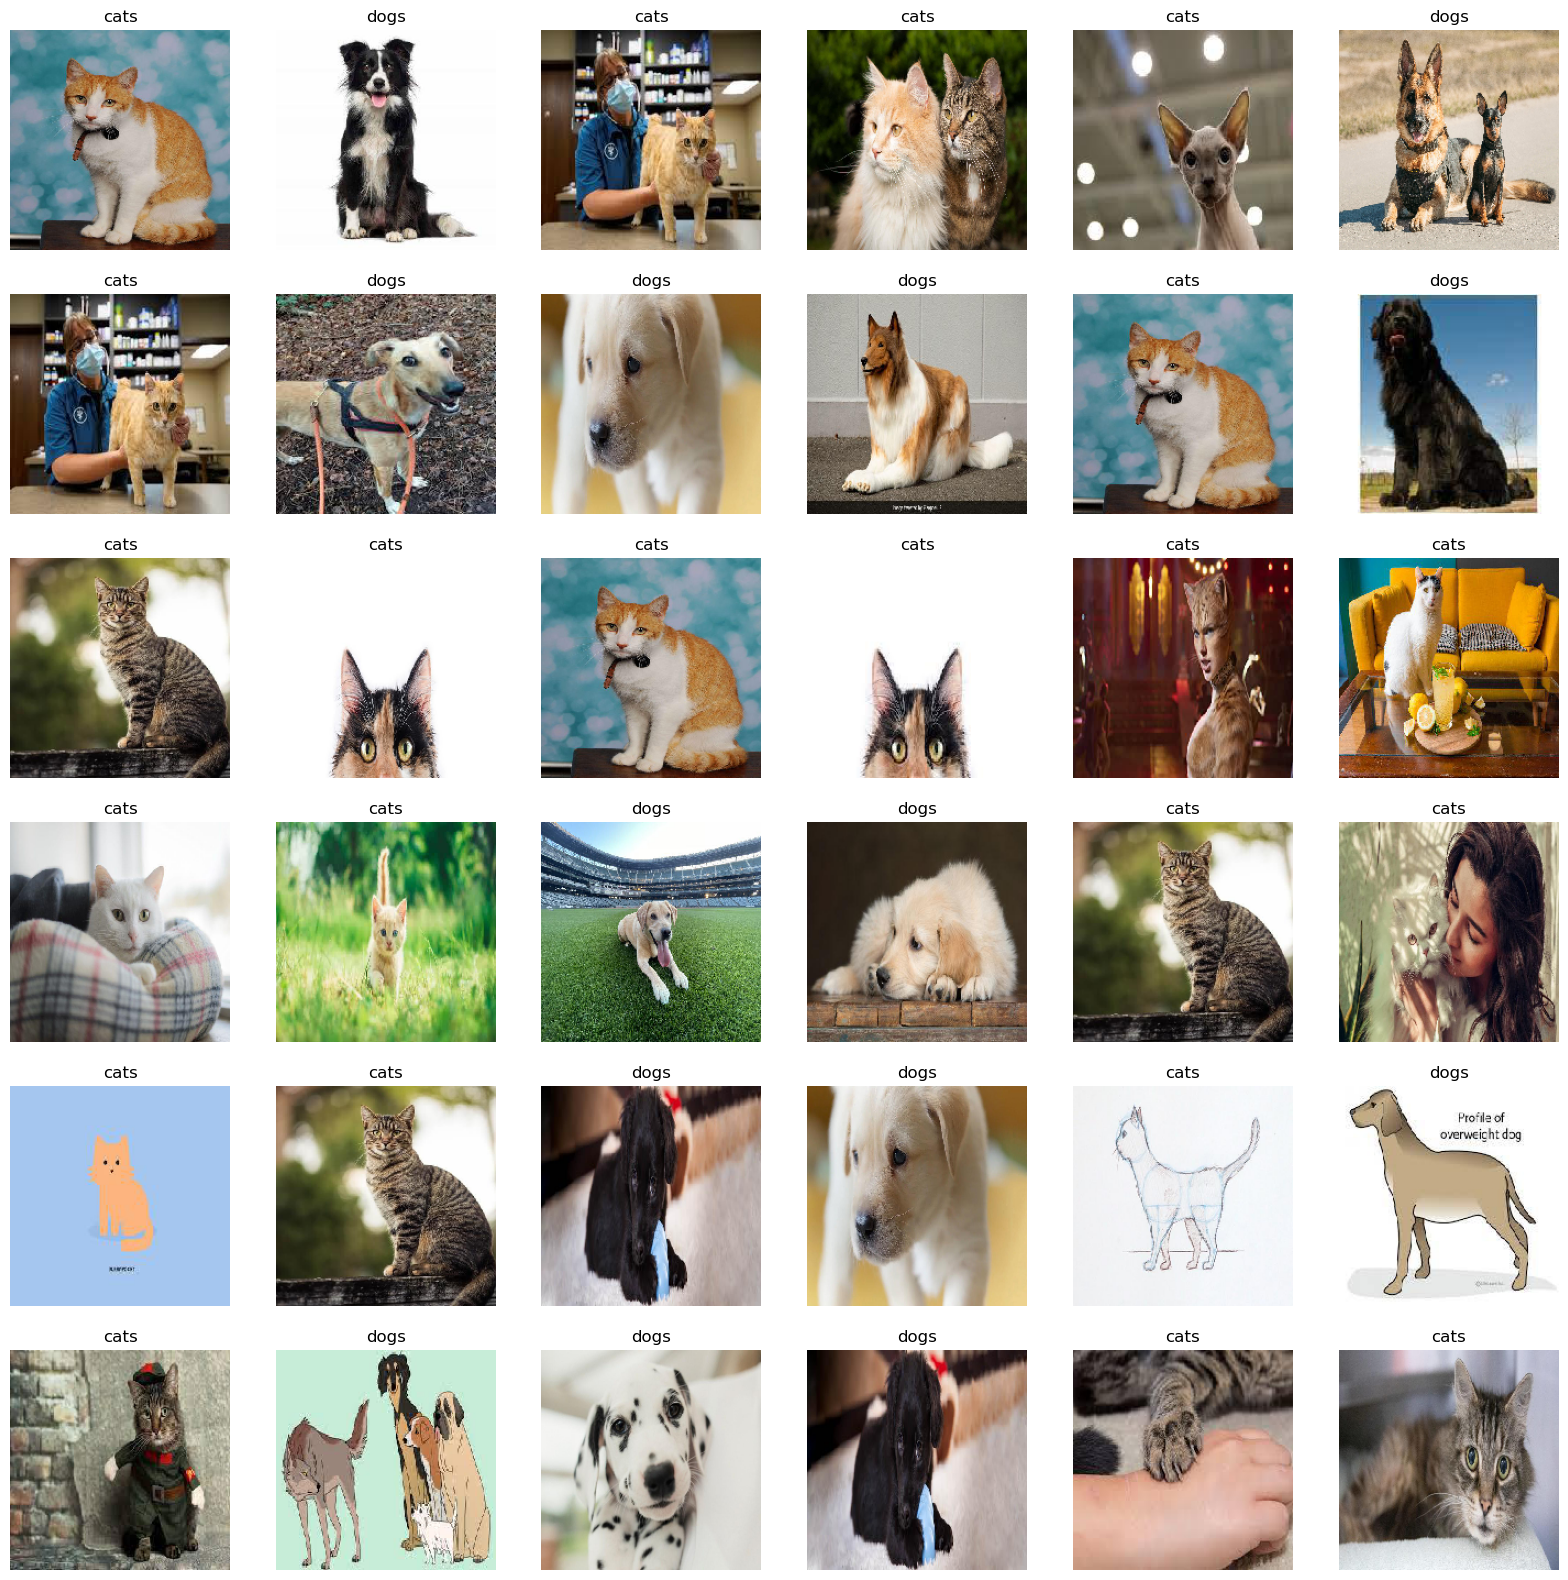

In [12]:
Show_Images(test_generator)

## Early Stopping

In [13]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

## Reduction learning_rate

In [14]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

# Exponential Decay

In [15]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)


In [16]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

# Transfer Learning

## Get the weights from DenseNet121

In [17]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

Freeze the layers of DenseNet121

In [18]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Membuat Model

In [19]:
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)               9437440   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

## Set the optimizer

In [20]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [21]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

# Training the model

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/5
8/8 [==============================] - 63s 7s/step - loss: 98.0537 - accuracy: 0.5605 - val_loss: 5.8721 - val_accuracy: 0.5469 - lr: 0.0100
Epoch 2/5
8/8 [==============================] - 49s 6s/step - loss: 4.6424 - accuracy: 0.7627 - val_loss: 1.1597 - val_accuracy: 0.8828 - lr: 0.0099
Epoch 3/5
8/8 [==============================] - 47s 6s/step - loss: 1.3167 - accuracy: 0.9067 - val_loss: 1.1568 - val_accuracy: 0.9141 - lr: 0.0098
Epoch 4/5
8/8 [==============================] - 47s 6s/step - loss: 0.4190 - accuracy: 0.9209 - val_loss: 0.5118 - val_accuracy: 0.9297 - lr: 0.0098
Epoch 5/5
8/8 [==============================] - 41s 5s/step - loss: 0.1554 - accuracy: 0.9432 - val_loss: 1.3773 - val_accuracy: 0.8984 - lr: 0.0097


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_accuracy',  
                             save_best_only=True,    
                             mode='max',              
                             verbose=1)              

history = model.fit(train_generator, 
                    epochs=5, 
                    callbacks=[checkpoint],   
                    validation_data=test_generator)


Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9354
Epoch 1: val_accuracy improved from -inf to 0.90714, saving model to best_model_weights.h5


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 58s 7s/step - loss: 0.1939 - accuracy: 0.9354 - val_loss: 2.1652 - val_accuracy: 0.9071
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9156
Epoch 2: val_accuracy improved from 0.90714 to 0.95000, saving model to best_model_weights.h5
9/9 [==============================] - 56s 6s/step - loss: 0.2437 - accuracy: 0.9156 - val_loss: 0.2859 - val_accuracy: 0.9500
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9408
Epoch 3: val_accuracy did not improve from 0.95000
9/9 [==============================] - 45s 5s/step - loss: 0.1371 - accuracy: 0.9408 - val_loss: 0.2141 - val_accuracy: 0.9214
Epoch 4/5
3/9 [=========>....................] - ETA: 34s - loss: 0.1366 - accuracy: 0.9323

# Evaluate The Model

## Evaluate The Validation

In [ ]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.702918529510498
Test accuracy: 0.9142857193946838


## Accuracy Graph

<Figure size 640x480 with 0 Axes>

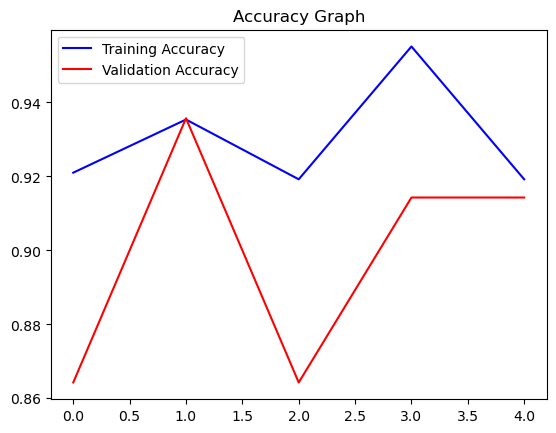

<Figure size 640x480 with 0 Axes>

In [ ]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

## Loss Graph

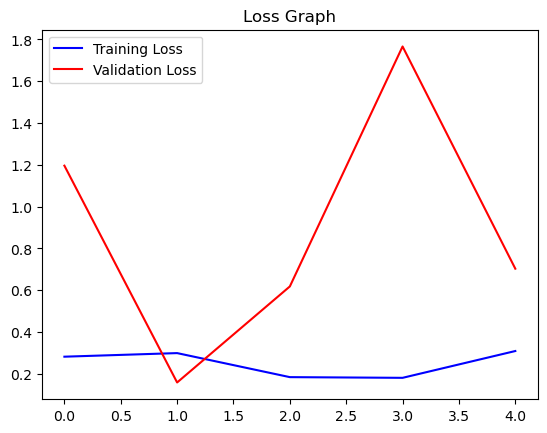

In [ ]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Confusion Matrix

3/3 [==============================] - 14s 2s/step


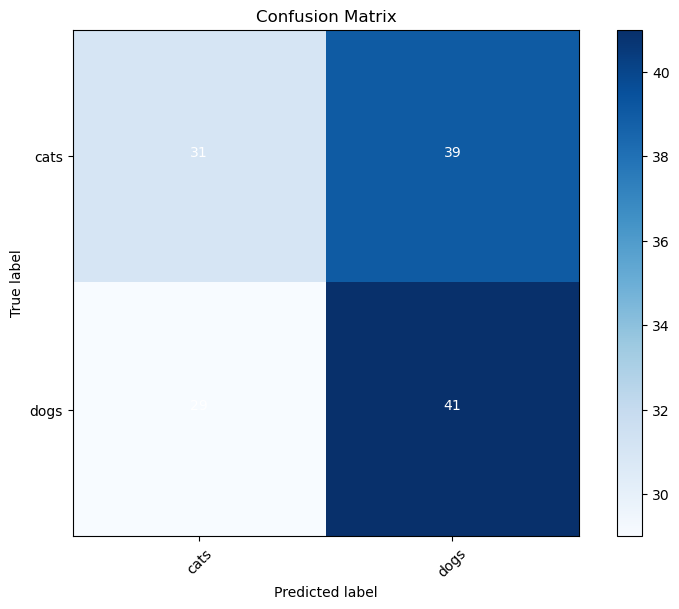

In [ ]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()


## Generate predictions for the test data

3/3 [==============================] - 9s 2s/step


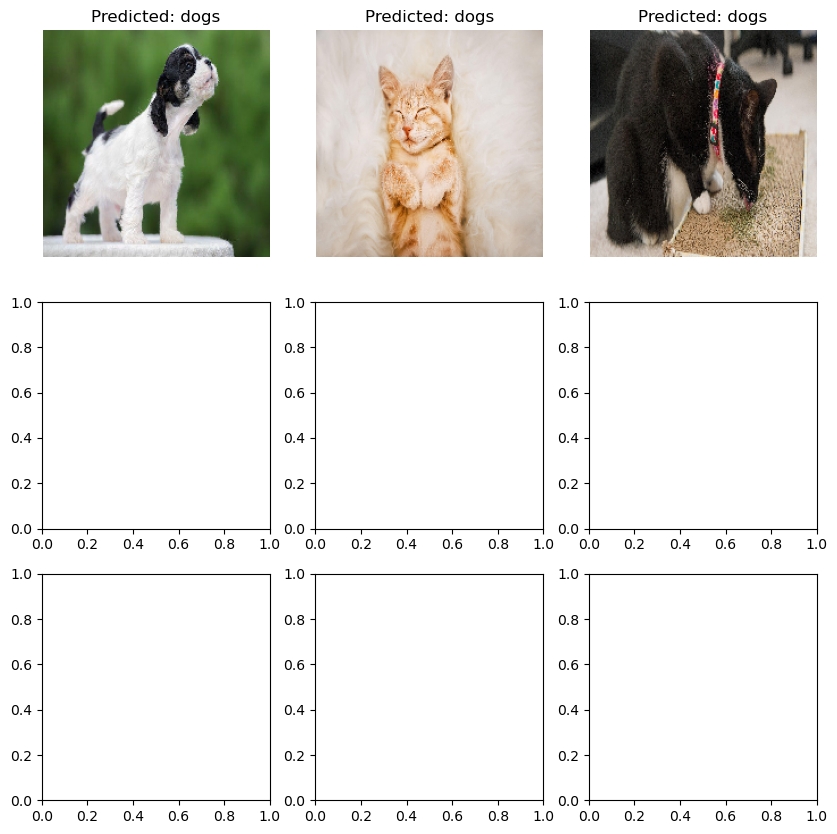

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [ ]:
# Generate predictions for the test data
predictions = model.predict(test_generator)

# Retrieve true labels from the generator (assuming class_mode is 'categorical')
true_labels = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Plot images with true and predicted labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(min(9, len(test_generator))):
    plt.figure(figsize=(6, 6))
    
    # Plot the image
    ax = axes[i // 3, i % 3]
    image = test_generator[i][0][0]  # Access a single image from the batch
    ax.imshow(image)
    
    # True label
    true_label = class_labels[true_labels[i]]
    
    # Predicted label
    predicted_label = class_labels[np.argmax(predictions[i])]
    
    ax.set_title(f'Predicted: {predicted_label}')
    ax.axis('off')
    
plt.show()
